# RBC Model
### 0.0.1 --> started 20 Jan 2023

In [1]:
import os
import re
import warnings
# from cobra.io import *
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import equilibrator_api
from equilibrator_api import ComponentContribution, Q_
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
from mass.visualization import (
    plot_ensemble_phase_portrait, plot_ensemble_time_profile)
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)
# from cobra.io.json import *
import cobra_dict as c_d
import csv
import altair as alt
from minspan.minspan import minspan,nnz
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io import json, sbml
from mass.util import qcqa_model

mass_config = MassConfiguration()

mass_config.irreversible_Keq = float("inf")
# from minspan import minspan,nnz

MASSpy version: 0.1.6


In [2]:
maps_dir = os.path.abspath("maps")
data_dir = os.path.abspath("data")
dir = os.path.abspath("")
model_dir = os.path.abspath("models")
minspan_dir= os.path.abspath("minspans_csv")
# extra_dir=os.path.abspath("..")
# minspan_dir

### Getting reactions and metabolite data from RECON 3D

In [3]:
# making dataframe of metabolites

csv_met = os.path.join(data_dir,"rbc_met_gluco.csv")
met_csv_df = pd.read_csv(csv_met,index_col="id")
metabolite_info=met_csv_df.to_dict(orient='index')


### Loading MASS model

In [4]:
glycolysis = MassModel("Glycolysis")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-02


In [5]:
#  Add all the remaining metabolites involved in the pathway
# for met_id, info in metabolite_info.items():
#     met = MassMetabolite(met_id, name=info['name'], formula=info['formula'], 
#                            charge=info['charge'], compartment=info['compartment'])
#     glycolysis.add_metabolites(met)

In [6]:
import json

In [7]:
# Loading reaction data as JSON file to maintain data types as dictionaries 
rxn_json = os.path.join(data_dir,"rbc_rxn_glyco.json")
with open(rxn_json) as json_file:
    rxn_data = json.load(json_file)

In [8]:
# for reaction, info in rxn_data.items():
#     reaction_obj = MassReaction(reaction)
#     reaction_obj.id=reaction
#     reaction= reaction_obj.id
#     reaction_obj.lower_bound = info['lower_bound']
#     reaction_obj.upper_bound = info['upper_bound']
#     reaction_obj.name = info['name']
#     glycolysis.add_reaction(reaction_obj)
#     temp=info['metabolites']
#     reaction_obj.add_metabolites(temp)
#     print(reaction)

In [9]:
glc__D_c = MassMetabolite(
    "glc__D_c",
    name="D-Glucose",
    formula="C6H12O6",
    charge=0,
    compartment="c",
    fixed=False)

g6p_c = MassMetabolite(
    "g6p_c",
    name="D-Glucose 6-phosphate",
    formula="C6H11O9P",
    charge=-2,
    compartment="c",
    fixed=False)

f6p_c = MassMetabolite(
    "f6p_c",
    name="D-Fructose 6-phosphate",
    formula="C6H11O9P",
    charge=-2,
    compartment="c",
    fixed=False)

fdp_c = MassMetabolite(
    "fdp_c",
    name="D-Fructose 1,6-bisphosphate",
    formula="C6H10O12P2",
    charge=-4,
    compartment="c",
    fixed=False)

dhap_c = MassMetabolite(
    "dhap_c",
    name="Dihydroxyacetone phosphate",
    formula="C3H5O6P",
    charge=-2,
    compartment="c",
    fixed=False)

g3p_c = MassMetabolite(
    "g3p_c",
    name="Glyceraldehyde 3-phosphate",
    formula="C3H5O6P",
    charge=-2,
    compartment="c",
    fixed=False)

_13dpg_c = MassMetabolite(
    "_13dpg_c",
    name="3-Phospho-D-glyceroyl phosphate",
    formula="C3H4O10P2",
    charge=-4,
    compartment="c",
    fixed=False)

_3pg_c = MassMetabolite(
    "_3pg_c",
    name="3-Phospho-D-glycerate",
    formula="C3H4O7P",
    charge=-3,
    compartment="c",
    fixed=False)

_2pg_c = MassMetabolite(
    "_2pg_c",
    name="D-Glycerate 2-phosphate",
    formula="C3H4O7P",
    charge=-3,
    compartment="c",
    fixed=False)

pep_c = MassMetabolite(
    "pep_c",
    name="Phosphoenolpyruvate",
    formula="C3H2O6P",
    charge=-3,
    compartment="c",
    fixed=False)

pyr_c = MassMetabolite(
    "pyr_c",
    name="Pyruvate",
    formula="C3H3O3",
    charge=-1,
    compartment="c",
    fixed=False)

lac__L_c = MassMetabolite(
    "lac__L_c",
    name="L-Lactate",
    formula="C3H5O3",
    charge=-1,
    compartment="c",
    fixed=False)

nad_c = MassMetabolite(
    "nad_c",
    name="Nicotinamide adenine dinucleotide",
    formula="[NAD]-C21H26N7O14P2",
    charge=-1,
    compartment="c",
    fixed=False)

nadh_c = MassMetabolite(
    "nadh_c",
    name="Nicotinamide adenine dinucleotide - reduced",
    formula="[NAD]-C21H27N7O14P2",
    charge=-2,
    compartment="c",
    fixed=False)

atp_c = MassMetabolite(
    "atp_c",
    name="ATP",
    formula="C10H12N5O13P3",
    charge=-4,
    compartment="c",
    fixed=False)

adp_c = MassMetabolite(
    "adp_c",
    name="ADP",
    formula="C10H12N5O10P2",
    charge=-3,
    compartment="c",
    fixed=False)

amp_c = MassMetabolite(
    "amp_c",
    name="AMP",
    formula="C10H12N5O7P",
    charge=-2,
    compartment="c",
    fixed=False)

pi_c = MassMetabolite(
    "pi_c",
    name="Phosphate",
    formula="HPO4",
    charge=-2,
    compartment="c",
    fixed=False)

h_c = MassMetabolite(
    "h_c",
    name="H+",
    formula="H",
    charge=1,
    compartment="c",
    fixed=False)

h2o_c = MassMetabolite(
    "h2o_c",
    name="H2O",
    formula="H2O",
    charge=0,
    compartment="c",
    fixed=False)

In [10]:
HEX1 = MassReaction(
    "HEX1",
    name="Hexokinase (D-glucose:ATP)",
    subsystem=glycolysis.id,
    reversible=True)
HEX1.add_metabolites({
    glc__D_c: -1,
    atp_c: -1,
    adp_c: 1,
    g6p_c: 1,
    h_c: 1})

PGI = MassReaction(
    "PGI",
    name="Glucose-6-phosphate isomerase",
    subsystem=glycolysis.id,
    reversible=True)
PGI.add_metabolites({
    g6p_c: -1,
    f6p_c: 1})

PFK = MassReaction(
    "PFK",
    name="Phosphofructokinase",
    subsystem=glycolysis.id,
    reversible=True)
PFK.add_metabolites({
    f6p_c: -1,
    atp_c: -1,
    fdp_c: 1,
    adp_c: 1,
    h_c: 1})

FBA = MassReaction(
    "FBA",
    name="Fructose-bisphosphate aldolase",
    subsystem=glycolysis.id,
    reversible=True)
FBA.add_metabolites({
    fdp_c: -1,
    dhap_c: 1,
    g3p_c: 1})

TPI = MassReaction(
    "TPI",
    name="Triose-phosphate isomerase",
    subsystem=glycolysis.id,
    reversible=True)
TPI.add_metabolites({
    dhap_c: -1,
    g3p_c: 1})

GAPD = MassReaction(
    "GAPD",
    name="Glyceraldehyde-3-phosphate dehydrogenase",
    subsystem=glycolysis.id,
    reversible=True)
GAPD.add_metabolites({
    g3p_c: -1,
    nad_c: -1,
    pi_c: -1,
    _13dpg_c: 1,
    h_c: 1,
    nadh_c: 1})

PGK = MassReaction(
    "PGK",
    name="Phosphoglycerate kinase",
    subsystem=glycolysis.id,
    reversible=True)
PGK.add_metabolites({
    _13dpg_c: -1,
    adp_c: -1,
    _3pg_c: 1,
    atp_c: 1})

PGM = MassReaction(
    "PGM",
    name="Phosphoglycerate mutase",
    subsystem=glycolysis.id,
    reversible=True)
PGM.add_metabolites({
    _3pg_c: -1,
    _2pg_c: 1})

ENO = MassReaction(
    "ENO",
    name="Enolase",
    subsystem=glycolysis.id,
    reversible=True)
ENO.add_metabolites({
    _2pg_c: -1,
    h2o_c: 1,
    pep_c: 1})

PYK = MassReaction(
    "PYK",
    name="Pyruvate kinase",
    subsystem=glycolysis.id,
    reversible=True)
PYK.add_metabolites({
    pep_c: -1,
    h_c: -1,
    adp_c: -1,
    atp_c: 1,
    pyr_c: 1})

LDH_L = MassReaction(
    "LDH_L",
    name="L-lactate dehydrogenase",
    subsystem=glycolysis.id,
    reversible=True)
LDH_L.add_metabolites({
    h_c: -1,
    nadh_c: -1,
    pyr_c: -1,
    lac__L_c: 1,
    nad_c: 1})

ADK1 = MassReaction(
    "ADK1",
    name="Adenylate kinase",
    subsystem="Misc.",
    reversible=True)
ADK1.add_metabolites({
    adp_c: -2,
    amp_c: 1,
    atp_c: 1})

ATPM = MassReaction(
    "ATPM",
    name="ATP maintenance requirement",
    subsystem="Pseudoreaction",
    reversible=False)
ATPM.add_metabolites({
    atp_c: -1,
    h2o_c: -1,
    adp_c: 1,
    h_c: 1,
    pi_c: 1})

DM_nadh = MassReaction(
    "DM_nadh",
    name="Demand NADH",
    subsystem="Pseudoreaction",
    reversible=False)
DM_nadh.add_metabolites({
    nadh_c: -1,
    nad_c: 1,
    h_c: 1})


glycolysis.add_reactions([
    HEX1, PGI, PFK, FBA, TPI, GAPD, PGK,
    PGM, ENO, PYK, LDH_L, ADK1, ATPM, DM_nadh])

for reaction in glycolysis.reactions:
    print(reaction)

HEX1: atp_c + glc__D_c <=> adp_c + g6p_c + h_c
PGI: g6p_c <=> f6p_c
PFK: atp_c + f6p_c <=> adp_c + fdp_c + h_c
FBA: fdp_c <=> dhap_c + g3p_c
TPI: dhap_c <=> g3p_c
GAPD: g3p_c + nad_c + pi_c <=> _13dpg_c + h_c + nadh_c
PGK: _13dpg_c + adp_c <=> _3pg_c + atp_c
PGM: _3pg_c <=> _2pg_c
ENO: _2pg_c <=> h2o_c + pep_c
PYK: adp_c + h_c + pep_c <=> atp_c + pyr_c
LDH_L: h_c + nadh_c + pyr_c <=> lac__L_c + nad_c
ADK1: 2 adp_c <=> amp_c + atp_c
ATPM: atp_c + h2o_c --> adp_c + h_c + pi_c
DM_nadh: nadh_c --> h_c + nad_c


In [11]:
# trial.add_boundary(trial.metabolites.get_by_id("nadh_c"), type="sink")
# trial.add_boundary(trial.metabolites.get_by_id("nad_c"), type="sink")


In [12]:
for r in glycolysis.reactions:
    print(r.id,  r.check_mass_balance())

HEX1 {}
PGI {}
PFK {}
FBA {}
TPI {}
GAPD {}
PGK {}
PGM {}
ENO {}
PYK {}
LDH_L {}
ADK1 {}
ATPM {}
DM_nadh {'charge': 2}


In [13]:
# sink_dict = {"SK_glc__D_c":1,
# "SK_lac__L_c": 1,
# "SK_pyr_c": 0.06,
# "SK_h_c":6.30957e-05,
#  "SK_h2o_c": 1,
#  "SK_amp_c": 1,
#  "DM_amp_c": 1}

# for i in sink_dict:
#     # print(sink_dict[i])
#     sink_rxn = glycolysis.boundary
#     sink_rxn.boundary_condition = sink_dict[i]



# glycolysis.reactions.get_by_id("SK_glc__D_c").reverse_stoichiometry(inplace=True)


In [14]:
SK_glc__D_c = glycolysis.add_boundary(
    metabolite=glc__D_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)
SK_glc__D_c.reverse_stoichiometry(inplace=True)

SK_lac__L_c = glycolysis.add_boundary(
    metabolite=lac__L_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)

SK_pyr_c = glycolysis.add_boundary(
    metabolite=pyr_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=0.06)

SK_h_c = glycolysis.add_boundary(
    metabolite=h_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=6.30957e-05)

SK_h2o_c = glycolysis.add_boundary(
    metabolite=h2o_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)

SK_amp_c = glycolysis.add_boundary(
    metabolite=amp_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)
SK_amp_c.reverse_stoichiometry(inplace=True)

DM_amp_c = glycolysis.add_boundary(
    metabolite=amp_c, boundary_type="demand", subsystem="Pseudoreaction",
    boundary_condition=1)

print("Boundary Reactions and Values\n-----------------------------")
for reaction in glycolysis.boundary:
    boundary_met = reaction.boundary_metabolite
    bc_value = glycolysis.boundary_conditions.get(boundary_met)
    print("{0}\n{1}: {2}\n".format(
        reaction, boundary_met, bc_value))

Boundary Reactions and Values
-----------------------------
SK_glc__D_c:  <=> glc__D_c
glc__D_b: 1.0

SK_lac__L_c: lac__L_c <=> 
lac__L_b: 1.0

SK_pyr_c: pyr_c <=> 
pyr_b: 0.06

SK_h_c: h_c <=> 
h_b: 6.30957e-05

SK_h2o_c: h2o_c <=> 
h2o_b: 1.0

SK_amp_c:  <=> amp_c
amp_b: 1.0

DM_amp_c: amp_c --> 
amp_b: 1.0



In [15]:
new_metabolite_order = [
    "glc__D_c", "g6p_c", "f6p_c", "fdp_c", "dhap_c",
    "g3p_c", "_13dpg_c", "_3pg_c", "_2pg_c", "pep_c",
    "pyr_c", "lac__L_c", "nad_c", "nadh_c", "amp_c",
    "adp_c", "atp_c", "pi_c", "h_c", "h2o_c"]

if len(glycolysis.metabolites) == len(new_metabolite_order):
    glycolysis.metabolites = DictList(
        glycolysis.metabolites.get_by_any(new_metabolite_order))

new_reaction_order = [
    "HEX1", "PGI", "PFK", "FBA", "TPI",
    "GAPD", "PGK", "PGM", "ENO", "PYK",
    "LDH_L", "DM_amp_c", "ADK1", "SK_pyr_c",
    "SK_lac__L_c", "ATPM", "DM_nadh", "SK_glc__D_c",
    "SK_amp_c", "SK_h_c", "SK_h2o_c"]

if len(glycolysis.reactions) == len(new_reaction_order):
    glycolysis.reactions = DictList(
        glycolysis.reactions.get_by_any(new_reaction_order))
glycolysis.update_S(array_type="DataFrame", dtype=int)

,HEX1,PGI,PFK,FBA,TPI,GAPD,PGK,PGM,ENO,PYK,...,DM_amp_c,ADK1,SK_pyr_c,SK_lac__L_c,ATPM,DM_nadh,SK_glc__D_c,SK_amp_c,SK_h_c,SK_h2o_c
glc__D_c,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
g6p_c,1,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f6p_c,0,1,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fdp_c,0,0,1,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dhap_c,0,0,0,1,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g3p_c,0,0,0,1,1,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_13dpg_c,0,0,0,0,0,1,-1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_3pg_c,0,0,0,0,0,0,1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
_2pg_c,0,0,0,0,0,0,0,1,-1,0,...,0,0,0,0,0,0,0,0,0,0
pep_c,0,0,0,0,0,0,0,0,1,-1,...,0,0,0,0,0,0,0,0,0,0


In [16]:
minspan_paths = [
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 1, -1, 0, 1, 0, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
glycolysis.compute_steady_state_fluxes(
    pathways=minspan_paths,
    independent_fluxes={
        SK_glc__D_c: 1.12,
        DM_nadh: .2 * 1.12,
        DM_amp_c: 0.014},
    update_reactions=True)

print("Steady State Fluxes\n-------------------")
for reaction, steady_state_flux in glycolysis.steady_state_fluxes.items():
    print("{0}: {1:.6f}".format(reaction.flux_symbol_str, steady_state_flux))

Steady State Fluxes
-------------------
v_HEX1: 1.120000
v_PGI: 1.120000
v_PFK: 1.120000
v_FBA: 1.120000
v_TPI: 1.120000
v_GAPD: 2.240000
v_PGK: 2.240000
v_PGM: 2.240000
v_ENO: 2.240000
v_PYK: 2.240000
v_LDH_L: 2.016000
v_DM_amp_c: 0.014000
v_ADK1: 0.000000
v_SK_pyr_c: 0.224000
v_SK_lac__L_c: 2.016000
v_ATPM: 2.240000
v_DM_nadh: 0.224000
v_SK_glc__D_c: 1.120000
v_SK_amp_c: 0.014000
v_SK_h_c: 2.688000
v_SK_h2o_c: 0.000000


In [17]:
glc__D_c.ic = 1.0
g6p_c.ic = 0.0486
f6p_c.ic = 0.0198
fdp_c.ic = 0.0146
g3p_c.ic = 0.00728
dhap_c.ic = 0.16
_13dpg_c.ic = 0.000243
_3pg_c.ic = 0.0773
_2pg_c.ic = 0.0113
pep_c.ic = 0.017
pyr_c.ic = 0.060301
lac__L_c.ic = 1.36
atp_c.ic = 1.6
adp_c.ic = 0.29
amp_c.ic = 0.0867281
h_c.ic = 0.0000899757
nad_c.ic = 0.0589
nadh_c.ic = 0.0301
pi_c.ic = 2.5
h2o_c.ic = 1.0

ic_info = pd.DataFrame()
met_list =[]
met_conc = []
print("Initial Conditions\n------------------")
for metabolite, ic_value in glycolysis.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))
    met_list.append(str(metabolite))
    met_conc.append(ic_value)

ic_info["metabolite"] = met_list
ic_info["concentrations"] = met_conc

Initial Conditions
------------------
glc__D_c: 1.0
g6p_c: 0.0486
f6p_c: 0.0198
fdp_c: 0.0146
dhap_c: 0.16
g3p_c: 0.00728
_13dpg_c: 0.000243
_3pg_c: 0.0773
_2pg_c: 0.0113
pep_c: 0.017
pyr_c: 0.060301
lac__L_c: 1.36
nad_c: 0.0589
nadh_c: 0.0301
amp_c: 0.0867281
adp_c: 0.29
atp_c: 1.6
pi_c: 2.5
h_c: 8.99757e-05
h2o_c: 1.0


In [18]:
ic_info=ic_info.set_index('metabolite')
ic_info

,concentrations
metabolite,
glc__D_c,1.000000
g6p_c,0.048600
f6p_c,0.019800
fdp_c,0.014600
dhap_c,0.160000
g3p_c,0.007280
_13dpg_c,0.000243
_3pg_c,0.077300
_2pg_c,0.011300


In [19]:
HEX1.Keq = 850
PGI.Keq = 0.41
PFK.Keq = 310
FBA.Keq = 0.082
TPI.Keq = 0.0571429
GAPD.Keq = 0.0179
PGK.Keq = 1800
PGM.Keq = 0.147059
ENO.Keq = 1.69492
PYK.Keq = 363000
LDH_L.Keq = 26300
ADK1.Keq = 1.65

SK_glc__D_c.Keq = mass_config.irreversible_Keq
SK_lac__L_c.Keq = 1
SK_pyr_c.Keq = 1
SK_h_c.Keq = 1
SK_h2o_c.Keq = 1
SK_amp_c.Keq = mass_config.irreversible_Keq

print("Equilibrium Constants\n---------------------")
for reaction in glycolysis.reactions:
    print("{0}: {1}".format(reaction.Keq_str, reaction.Keq))

Equilibrium Constants
---------------------
Keq_HEX1: 850
Keq_PGI: 0.41
Keq_PFK: 310
Keq_FBA: 0.082
Keq_TPI: 0.0571429
Keq_GAPD: 0.0179
Keq_PGK: 1800
Keq_PGM: 0.147059
Keq_ENO: 1.69492
Keq_PYK: 363000
Keq_LDH_L: 26300
Keq_DM_amp_c: inf
Keq_ADK1: 1.65
Keq_SK_pyr_c: 1
Keq_SK_lac__L_c: 1
Keq_ATPM: inf
Keq_DM_nadh: inf
Keq_SK_glc__D_c: inf
Keq_SK_amp_c: inf
Keq_SK_h_c: 1
Keq_SK_h2o_c: 1


### Running Concentration QP

In [20]:
for metabolite in ["h_c", 
"h2o_c"]:
    metabolite = glycolysis.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M

In [21]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    glycolysis,
    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(glycolysis.fixed))
# fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

['ADK1']
mass\util\util.py:159 UserWarning: Unrecognized kwargs: ['Keq_percent_deviation']
mass\thermo\conc_solution.py:98 FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
mass\thermo\conc_solution.py:99 FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,variables,reduced_costs
glc__D_c,1.000000,0.0
g6p_c,0.067683,0.0
f6p_c,0.014217,0.0
fdp_c,0.019261,0.0
dhap_c,0.164141,0.0
...,...,...
Keq_PGK,2515.633473,0.0
Keq_PGM,0.258293,0.0
Keq_ENO,2.431830,0.0
Keq_PYK,363000.000000,0.0


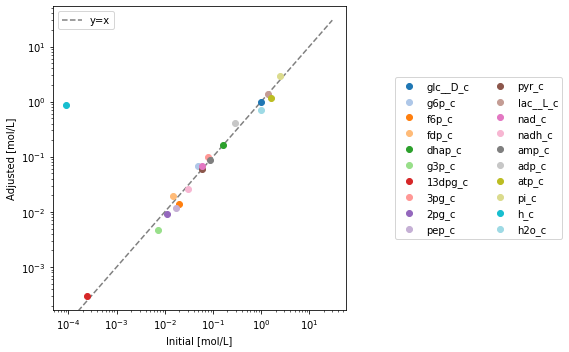

In [22]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=ic_info["concentrations"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in ic_info.index], ax=ax,
    legend="right outside", plot_function="loglog",
    # xlim=(1e-6,0.02), ylim=(1e-6,1e-1),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()


In [23]:
update_model_with_concentration_solution(
    glycolysis, conc_solution, concentrations=True, inplace=True);

In [24]:
conc_solution_adjusted = conc_solution.to_frame()
conc_fig_df = pd.DataFrame()
conc_fig_df["Initial"] = ic_info["concentrations"]
conc_fig_df["Adjusted"] = conc_solution_adjusted["variables"]
conc_fig_df["Metabolite"] = ic_info.index
# conc_fig_df

mass\thermo\conc_solution.py:98 FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
mass\thermo\conc_solution.py:99 FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [25]:
conc_fig_comp = alt.Chart(conc_fig_df).mark_circle(size= 100).encode(
    alt.X("Initial", axis=alt.Axis( tickCount=5), scale=alt.Scale(type='log')),
    alt.Y('Adjusted',axis=alt.Axis( tickCount=5), 
    scale=alt.Scale(type='log')), 

    alt.Color('Metabolite', scale=alt.Scale(scheme='turbo')), 
    tooltip=['Metabolite', "Initial", "Adjusted"]
).properties(
    width=400,
    height=400).interactive()
conc_fig_comp

alt.Chart(...)

 Getting Standard and Physiological Gibbs energies of reactions

In [ ]:
#  possibly running comparison tests b/w equilibrator and published values?


Caluclation of percs

In [26]:
percs = glycolysis.calculate_PERCs(update_reactions=True)

# percs = glycolysis.calculate_PERCs(
#     fluxes={
#         r: v for r, v in glycolysis.steady_state_fluxes.items()
#         if not r.boundary},
#     update_reactions=True)

percs_df = pd.DataFrame()
print("Forward Rate Constants\n----------------------")
for reaction in glycolysis.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

percs_df = pd.DataFrame.from_dict(percs, orient='index', columns = ["OG"])

Forward Rate Constants
----------------------
kf_HEX1: 0.978329
kf_PGI: 26.177931
kf_PFK: 68.917047
kf_FBA: 91.989074
kf_TPI: 10.794445
kf_GAPD: 4291.312229
kf_PGK: 29487.028034
kf_PGM: 36.477347
kf_ENO: 513.928049
kf_PYK: 466.473991
kf_LDH_L: 1274.950957
kf_DM_amp_c: 0.161424
kf_ADK1: 100000.000000
kf_SK_pyr_c: 744.186047
kf_SK_lac__L_c: 5.600000
kf_ATPM: 1.956604
kf_DM_nadh: 8.523509
kf_SK_glc__D_c: 1.120000
kf_SK_amp_c: 0.014000
kf_SK_h_c: 3.078914
kf_SK_h2o_c: 100000.000000


### Perc sampling

In [27]:
seed = int(1)
n_models = 1500

first trying with 1 order of magnitude

In [28]:
conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(glycolysis.fixed),
    # fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    )
for variable in conc_solver.variables:
    try:
        met = glycolysis.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 5, met.ic * 5])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models,  processes=4, seed=seed)
conc_samples.head()


Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp3yzyixh2.lp
Reading time = 0.00 seconds
: 20 rows, 42 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpjarfdikb.lp
Reading time = 0.00 seconds
: 11 rows, 31 columns, 53 nonzeros


,glc__D_c,g6p_c,f6p_c,fdp_c,dhap_c,g3p_c,_13dpg_c,_3pg_c,_2pg_c,pep_c,pyr_c,lac__L_c,nad_c,nadh_c,amp_c,adp_c,atp_c,pi_c,h_c,h2o_c
0,2.462065,0.297164,0.005629,0.005994,0.114823,0.000983,0.000110,0.078778,0.006477,0.011417,0.200404,2.382247,0.180226,0.014906,0.034759,0.330271,0.467465,0.617762,0.184012,0.313181
1,2.242641,0.308981,0.036277,0.013779,0.098502,0.002192,0.000287,0.083724,0.005458,0.012210,0.122339,0.437371,0.078217,0.007171,0.023136,0.928193,0.479299,0.682557,0.192961,0.275982
2,2.031364,0.190062,0.034682,0.005382,0.045065,0.001240,0.000117,0.033540,0.002688,0.006492,0.123787,0.456632,0.096068,0.013526,0.049200,1.815705,1.117184,0.850535,0.255071,0.307006
3,1.877906,0.205045,0.032162,0.013293,0.107946,0.001950,0.000236,0.100210,0.007642,0.012459,0.158813,1.049436,0.117241,0.032722,0.059031,0.781503,1.455357,2.617723,0.528624,0.316691
4,1.143786,0.182102,0.007715,0.054211,0.253607,0.004516,0.000461,0.118603,0.005564,0.009716,0.222136,0.654076,0.157525,0.017617,0.026267,1.622259,0.997164,2.998693,0.673409,0.176744


In [29]:
boundary_metabolites = []
for m in glycolysis.boundary:
    for i in (m.metabolites.keys()):
        if str(i) not in boundary_metabolites:
            boundary_metabolites.append(str(i))
            print(i)

amp_c
pyr_c
lac__L_c
glc__D_c
h_c
h2o_c


In [1]:
metabolite_ids = [m.id for m in glycolysis.metabolites]
misbalance= pd.DataFrame(
    glycolysis.S.dot(np.array(list(glycolysis.steady_state_fluxes.values()))),
    index=metabolite_ids,
    columns=[r"$\textbf{Sv}_{\mathrm{stst}}$"])
misbalance.T

NameError: name 'glycolysis' is not defined

In [31]:
# Determine imbalances in the reduced network
fluxes = np.array(list(glycolysis.steady_state_fluxes.values()))
imbalanced_metabolites = glycolysis.S.dot(fluxes)

# Iterate through metabolites
for mid, imbalance in imbalanced_metabolites.iteritems():
    met = glycolysis.metabolites.get_by_id(mid)
    if imbalance != 0:
        if str(mid) not in boundary_metabolites:
            print(mid)

nad_c
nadh_c


In [47]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = glycolysis.copy()
    new_model.id += "_C{0:d}".format(idx)
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())

    # Determine imbalances in the reduced network
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)

    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0:
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)
        if str(mid) not in boundary_metabolites:
            print(mid)
            # Add boundary reactions for imbalanced metabolites
            boundary_type = "sink"    
            # Add boundary reaction with imbalance as flux value
            boundary_reaction = new_model.add_boundary(
                mid, boundary_type, boundary_condition=met.ic)

            boundary_reaction.Keq = 1
            if imbalance < 0:
                boundary_reaction.reverse_stoichiometry(inplace=True)
                imbalance = -imbalance

            boundary_reaction.kf = imbalance / met.ic
            boundary_reaction.steady_state_flux = imbalance
            try:
                # Update PERCs
                percs = new_model.calculate_PERCs(
                    fluxes={
                        r: v for r, v in new_model.steady_state_fluxes.items()
                        if not r.boundary},
                    update_reactions=True)
            except:
                print("Negative PERCs for {0}".format(new_model.id))
                continue




    df_p = pd.DataFrame.from_dict(percs, orient='index')
    df_p.columns = [("No."+ str(idx))]
    percs_df = pd.merge(percs_df, df_p, how='inner', left_index=True, right_index=True)
        # except:
        #     print("Negative PERCs for {0}".format(new_model.id))

        #     df_p = pd.DataFrame.from_dict(percs, orient='index')
        #     df_p.columns = [("No."+ str(idx))]
        #     percs_df = pd.merge(percs_df, df_p, how='inner', left_index=True, right_index=True)
        #     percs_df = pd.join([percs_df, df_p])
            
        #     continue



        
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(
    len(models_for_ensemble)))

Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp972iue98.lp
Reading time = 0.00 seconds
: 20 rows, 42 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpcr6aj_if.lp
Reading time = 0.00 seconds
: 20 rows, 42 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpya9cn0i0.lp
Reading time = 0.00 seconds
: 11 rows, 31 columns, 53 nonzeros
nad_c
nadh_c
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpftvl_7il.lp
Reading time = 0.00 seconds
: 20 rows, 42 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmprxcu7_eo.lp
Reading time = 0.01 seconds
: 20 rows, 42 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpoz6epeue.lp
Reading time = 0.00 seconds
: 11 rows, 31 columns, 53 nonzeros
nad_c
nadh_c
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpg80w8fg5.lp
Reading time = 0.00 seconds
: 20

#### Trying to simulate

In [34]:
# Set the logger
from mass.util.util import (
    _check_kwargs,
    _log_msg,
    _make_logger,
    apply_decimal_precision,
    ensure_iterable,
)
MASSCONFIGURATION = MassConfiguration()
# If working in Python application (e.g. iPython notebooks), enable logging

# Set the logger
import roadrunner
LOGGER = _make_logger(__name__)

"""logging.Logger: Logger for :mod:`~mass.simulation.simulation` submodule."""


RR_LOGGER = roadrunner.Logger

"""roadrunner.Logger: The logger for the :mod:`roadrunner`."""
RR_LOGGER.disableLogging()

In [107]:
# Ensure all models are simulated to a long time and that
# there are enough time points to determine if model reached steady state.
tfinal = 1e4
verbose = False
sim = Simulation(reference_model=models_for_ensemble[0], verbose=verbose)
sim.add_models(models_for_ensemble[1:], verbose=verbose, disable_safe_load=True)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

models_to_export = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model in models_for_ensemble:
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " first attempt failed.")
        # First attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 10, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " second attempt failed.")
        # Second attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 100, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " third attempt failed. Eliminating model.")
        # Third attempt was not successful, eliminate the model
        sim.remove_models(models=model, verbose=verbose)

ERROR: Unable to find a steady state for 'Glycolysis_C31' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C31", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C31' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C31", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C31 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C31' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C31", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C31 second attempt failed.
Glycolysis_C31 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C39' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C39", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C39' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C39", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C39 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C39' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C39", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C39 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C40' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C40", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C39 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C40' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C40", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C40 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C40' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C40", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C40 second attempt failed.
Glycolysis_C40 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C42' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C42", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C42' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C42", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C42 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C42' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C42", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C42 second attempt failed.
Glycolysis_C42 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C80' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C80", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C80' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C80", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C80 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C80' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C80", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C80 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C81' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C81", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C80 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C81' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C81", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C81 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C81' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C81", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C81 second attempt failed.
Glycolysis_C81 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C85' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C85", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C85' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C85", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C85 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C85' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C85", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C85 second attempt failed.
Glycolysis_C85 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C89' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C89", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C89' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C89", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C89 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C89' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C89", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C89 second attempt failed.
Glycolysis_C89 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C91' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C91", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C91' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C91", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C91 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C91' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C91", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C91 second attempt failed.
Glycolysis_C91 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C93' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C93", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C93' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C93", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C93 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C93' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C93", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C93 second attempt failed.
Glycolysis_C93 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C99' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C99", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C99' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C99", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C99 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C99' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C99", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C99 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C100' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C100", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C99 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C100' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C100", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C100 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C100' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C100", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C100 second attempt failed.
Glycolysis_C100 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C124' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C124", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C124' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C124", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C124 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C124' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C124", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C124 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C125' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C125", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C124 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C125' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C125", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C125 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C125' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C125", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C125 second attempt failed.
Glycolysis_C125 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C156' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C156", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C156' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C156", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C156 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C156' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C156", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C156 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C157' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C157", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C156 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C157' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C157", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C157 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C157' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C157", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C157 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C158' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C158", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C157 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C158' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C158", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C158 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C158' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C158", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C158 second attempt failed.
Glycolysis_C158 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C163' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C163", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C163' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C163", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C163 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C163' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C163", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C163 second attempt failed.
Glycolysis_C163 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C165' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C165", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C165' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C165", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C165 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C165' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C165", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C165 second attempt failed.
Glycolysis_C165 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C170' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C170", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C170' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C170", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C170 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C170' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C170", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C170 second attempt failed.
Glycolysis_C170 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C182' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C182", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C182' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C182", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C182 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C182' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C182", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C182 second attempt failed.
Glycolysis_C182 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C199' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C199", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C199' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C199", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C199 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C199' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C199", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C199 second attempt failed.
Glycolysis_C199 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C222' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C222", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C222' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C222", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C222 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C222' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C222", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C222 second attempt failed.
Glycolysis_C222 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C252' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C252", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C252' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C252", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C252 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C252' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C252", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C252 second attempt failed.
Glycolysis_C252 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C296' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C296", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C296' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C296", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C296 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C296' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C296", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C296 second attempt failed.
Glycolysis_C296 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C305' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C305", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C305' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C305", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C305 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C305' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C305", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C305 second attempt failed.
Glycolysis_C305 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C307' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C307", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C307' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C307", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C307 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C307' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C307", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C307 second attempt failed.
Glycolysis_C307 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C322' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C322", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C322' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C322", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C322 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C322' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C322", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C322 second attempt failed.
Glycolysis_C322 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C377' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C377", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C377' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C377", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C377 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C377' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C377", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C377 second attempt failed.
Glycolysis_C377 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C379' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C379", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C379' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C379", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C379 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C379' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C379", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C379 second attempt failed.
Glycolysis_C379 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C381' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C381", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C381' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C381", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C381 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C381' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C381", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C381 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C382' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C382", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C381 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C382' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C382", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C382 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C382' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C382", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C382 second attempt failed.
Glycolysis_C382 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C390' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C390", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C390' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C390", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C390 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C390' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C390", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C390 second attempt failed.
Glycolysis_C390 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C403' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C403", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C403' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C403", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C403 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C403' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C403", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C403 second attempt failed.
Glycolysis_C403 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C413' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C413", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C413' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C413", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C413 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C413' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C413", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C413 second attempt failed.
Glycolysis_C413 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C426' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C426", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C426' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C426", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C426 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C426' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C426", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C426 second attempt failed.
Glycolysis_C426 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C437' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C437", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C437' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C437", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C437 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C437' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C437", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C437 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C438' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C438", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C437 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C438' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C438", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C438 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C438' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C438", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C438 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C439' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C439", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C438 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C439' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C439", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C439 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C439' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C439", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C439 second attempt failed.
Glycolysis_C439 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C442' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C442", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C442' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C442", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C442 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C442' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C442", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C442 second attempt failed.
Glycolysis_C442 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C482' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C482", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C482' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C482", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C482 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C482' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C482", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C482 second attempt failed.
Glycolysis_C482 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C488' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C488", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C488' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C488", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C488 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C488' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C488", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C488 second attempt failed.
Glycolysis_C488 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C523' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C523", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C523' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C523", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C523 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C523' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C523", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C523 second attempt failed.
Glycolysis_C523 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C530' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C530", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C530' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C530", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C530 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C530' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C530", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C530 second attempt failed.
Glycolysis_C530 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C533' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C533", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C533' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C533", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C533 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C533' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C533", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C533 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C534' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C534", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C533 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C534' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C534", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C534 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C534' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C534", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C534 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C535' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C535", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C534 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C535' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C535", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C535 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C535' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C535", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C535 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C536' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C536", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C535 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C536' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C536", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C536 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C536' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C536", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C536 second attempt failed.
Glycolysis_C536 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C539' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C539", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C539' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C539", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C539 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C539' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C539", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C539 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C540' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C540", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C539 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C540' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C540", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C540 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C540' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C540", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C540 second attempt failed.
Glycolysis_C540 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C598' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C598", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C598' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C598", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C598 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C598' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C598", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C598 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C599' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C599", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C598 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C599' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C599", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C599 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C599' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C599", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C599 second attempt failed.
Glycolysis_C599 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C610' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C610", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C610' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C610", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C610 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C610' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C610", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C610 second attempt failed.
Glycolysis_C610 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C629' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C629", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C629' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C629", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C629 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C629' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C629", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C629 second attempt failed.
Glycolysis_C629 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C655' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C655", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C655' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C655", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C655 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C655' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C655", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C655 second attempt failed.
Glycolysis_C655 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C673' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C673", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C673' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C673", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C673 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C673' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C673", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C673 second attempt failed.
Glycolysis_C673 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C677' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C677", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C677' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C677", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C677 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C677' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C677", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C677 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C678' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C678", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C677 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C678' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C678", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C678 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C678' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C678", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C678 second attempt failed.
Glycolysis_C678 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C683' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C683", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C683' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C683", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C683 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C683' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C683", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C683 second attempt failed.
Glycolysis_C683 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C694' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C694", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C694' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C694", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C694 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C694' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C694", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C694 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C695' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C695", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C694 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C695' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C695", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C695 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C695' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C695", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C695 second attempt failed.
Glycolysis_C695 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C701' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C701", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C701' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C701", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C701 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C701' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C701", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C701 second attempt failed.
Glycolysis_C701 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C742' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C742", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C742' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C742", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C742 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C742' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C742", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C742 second attempt failed.
Glycolysis_C742 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C750' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C750", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C750' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C750", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C750 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C750' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C750", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C750 second attempt failed.
Glycolysis_C750 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C760' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C760", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C760' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C760", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C760 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C760' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C760", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C760 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C761' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C761", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C760 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C761' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C761", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C761 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C761' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C761", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C761 second attempt failed.
Glycolysis_C761 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C764' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C764", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C764' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C764", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C764 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C764' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C764", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C764 second attempt failed.
Glycolysis_C764 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C778' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C778", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C778' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C778", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C778 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C778' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C778", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C778 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C779' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C779", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C778 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C779' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C779", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C779 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C779' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C779", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C779 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C780' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C780", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C779 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C780' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C780", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C780 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C780' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C780", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C780 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C781' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C781", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C780 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C781' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C781", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C781 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C781' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C781", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C781 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C782' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C782", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C781 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C782' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C782", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C782 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C782' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C782", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C782 second attempt failed.
Glycolysis_C782 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C785' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C785", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C785' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C785", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C785 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C785' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C785", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C785 second attempt failed.
Glycolysis_C785 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C826' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C826", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C826' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C826", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C826 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C826' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C826", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C826 second attempt failed.
Glycolysis_C826 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C831' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C831", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C831' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C831", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C831 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C831' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C831", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C831 second attempt failed.
Glycolysis_C831 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C833' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C833", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C833' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C833", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C833 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C833' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C833", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C833 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C834' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C834", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C833 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C834' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C834", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C834 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C834' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C834", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C834 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C835' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C835", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C834 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C835' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C835", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C835 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C835' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C835", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C835 second attempt failed.
Glycolysis_C835 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C859' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C859", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C859' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C859", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C859 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C859' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C859", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C859 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C860' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C860", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C859 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C860' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C860", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C860 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C860' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C860", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C860 second attempt failed.
Glycolysis_C860 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C863' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C863", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C863' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C863", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C863 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C863' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C863", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C863 second attempt failed.
Glycolysis_C863 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C867' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C867", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C867' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C867", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C867 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C867' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C867", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C867 second attempt failed.
Glycolysis_C867 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C905' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C905", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C905' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C905", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C905 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C905' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C905", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C905 second attempt failed.
Glycolysis_C905 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C918' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C918", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C918' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C918", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C918 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C918' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C918", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C918 second attempt failed.
Glycolysis_C918 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C923' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C923", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C923' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C923", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C923 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C923' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C923", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C923 second attempt failed.
Glycolysis_C923 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C926' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C926", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C926' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C926", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C926 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C926' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C926", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C926 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C927' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C927", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C926 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C927' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C927", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C927 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C927' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C927", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C927 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C928' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C928", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C927 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C928' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C928", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C928 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C928' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C928", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C928 second attempt failed.
Glycolysis_C928 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C960' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C960", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C960' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C960", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C960 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C960' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C960", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C960 second attempt failed.
Glycolysis_C960 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C966' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C966", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C966' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C966", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C966 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C966' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C966", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C966 second attempt failed.
Glycolysis_C966 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C968' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C968", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C968' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C968", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C968 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C968' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C968", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C968 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C969' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C969", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C968 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C969' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C969", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C969 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C969' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C969", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C969 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C970' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C970", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C969 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C970' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C970", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C970 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C970' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C970", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C970 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C971' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C971", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C970 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C971' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C971", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C971 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C971' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C971", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C971 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C972' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C972", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C971 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C972' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C972", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C972 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C972' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C972", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C972 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C973' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C973", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C972 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C973' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C973", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C973 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C973' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C973", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C973 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C974' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C974", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C973 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C974' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C974", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C974 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C974' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C974", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C974 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C975' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C975", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C974 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C975' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C975", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C975 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C975' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C975", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C975 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C976' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C976", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C975 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C976' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C976", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C976 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C976' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C976", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C976 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C977' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C977", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C976 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C977' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C977", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C977 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C977' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C977", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C977 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C978' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C978", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C977 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C978' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C978", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C978 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C978' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C978", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C978 second attempt failed.
Glycolysis_C978 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C981' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C981", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C981' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C981", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C981 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C981' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C981", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C981 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C982' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C982", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C981 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C982' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C982", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C982 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C982' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C982", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C982 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C983' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C983", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C982 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C983' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C983", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C983 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C983' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C983", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C983 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C984' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C984", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C983 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C984' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C984", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C984 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C984' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C984", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C984 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C985' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C985", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C984 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C985' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C985", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C985 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C985' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C985", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C985 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C986' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C986", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C985 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C986' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C986", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C986 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C986' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C986", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C986 second attempt failed.
Glycolysis_C986 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C991' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C991", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C991' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C991", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C991 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C991' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C991", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C991 second attempt failed.
Glycolysis_C991 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C993' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C993", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C993' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C993", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C993 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C993' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C993", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C993 second attempt failed.
Glycolysis_C993 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C995' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C995", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C995' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C995", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C995 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C995' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C995", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C995 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C996' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C996", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C995 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C996' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C996", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C996 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C996' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C996", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C996 second attempt failed.
Glycolysis_C996 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1007' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1007", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1007' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1007", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C1007 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1007' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1007", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C1007 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1008' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1008", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1007 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1008' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1008", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1008 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1008' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1008", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1008 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1009' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1009", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1008 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1009' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1009", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1009 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1009' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1009", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1009 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1010' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1010", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1009 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1010' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1010", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1010 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1010' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1010", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1010 second attempt failed.
Glycolysis_C1010 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1012' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1012", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1012' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1012", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1012 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1012' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1012", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1012 second attempt failed.
Glycolysis_C1012 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1014' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1014", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1014' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1014", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1014 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1014' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1014", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1014 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1015' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1015", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1014 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1015' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1015", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1015 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1015' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1015", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1015 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1016' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1016", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1015 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1016' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1016", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1016 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1016' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1016", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1016 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1017' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1017", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1016 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1017' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1017", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1017 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1017' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1017", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1017 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1018' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1018", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1017 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1018' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1018", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1018 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1018' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1018", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1018 second attempt failed.
Glycolysis_C1018 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1037' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1037", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1037' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1037", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]']" is greater than the steady state threshold.


Glycolysis_C1037 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1037' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1037", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C1037 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1038' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1038", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C1037 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1038' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1038", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C1038 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1038' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1038", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C1038 second attempt failed.
Glycolysis_C1038 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1045' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1045", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1045' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1045", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C1045 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1045' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1045", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C1045 second attempt failed.
Glycolysis_C1045 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1049' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1049", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1049' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1049", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1049 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1049' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1049", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1049 second attempt failed.
Glycolysis_C1049 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1053' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1053", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1053' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1053", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C1053 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1053' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1053", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C1053 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1054' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1054", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1053 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1054' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1054", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1054 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1054' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1054", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1054 second attempt failed.
Glycolysis_C1054 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1060' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1060", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1060' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1060", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C1060 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1060' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1060", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C1060 second attempt failed.
Glycolysis_C1060 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1104' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1104", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1104' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1104", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1104 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1104' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1104", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1104 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1105' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1105", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1104 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1105' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1105", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1105 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1105' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1105", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1105 second attempt failed.
Glycolysis_C1105 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1140' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1140", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1140' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1140", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C1140 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1140' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1140", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C1140 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1141' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1141", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C1140 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1141' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1141", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C1141 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1141' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1141", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C1141 second attempt failed.
Glycolysis_C1141 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1214' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1214", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1214' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1214", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1214 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1214' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1214", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1214 second attempt failed.
Glycolysis_C1214 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1216' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1216", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1216' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1216", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1216 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1216' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1216", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1216 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1217' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1217", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1216 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1217' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1217", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1217 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1217' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1217", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1217 second attempt failed.
Glycolysis_C1217 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1219' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1219", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1219' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1219", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1219 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1219' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1219", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1219 second attempt failed.
Glycolysis_C1219 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1221' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1221", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1221' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1221", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1221 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1221' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1221", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1221 second attempt failed.
Glycolysis_C1221 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1229' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1229", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1229' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1229", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1229 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1229' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1229", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1229 second attempt failed.
Glycolysis_C1229 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1233' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1233", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1233' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1233", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1233 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1233' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1233", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1233 second attempt failed.
Glycolysis_C1233 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1240' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1240", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1240' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1240", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1240 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1240' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1240", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1240 second attempt failed.
Glycolysis_C1240 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1244' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1244", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1244' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1244", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1244 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1244' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1244", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1244 second attempt failed.
Glycolysis_C1244 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1250' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1250", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1250' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1250", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1250 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1250' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1250", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1250 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1251' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1251", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1250 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1251' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1251", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1251 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1251' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1251", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1251 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1252' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1252", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1251 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1252' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1252", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1252 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1252' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1252", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1252 second attempt failed.
Glycolysis_C1252 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1254' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1254", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1254' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1254", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1254 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1254' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1254", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1254 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1255' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1255", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1254 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1255' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1255", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1255 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1255' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1255", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1255 second attempt failed.
Glycolysis_C1255 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1258' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1258", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1258' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1258", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1258 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1258' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1258", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1258 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1259' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1259", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1258 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1259' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1259", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1259 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1259' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1259", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1259 second attempt failed.
Glycolysis_C1259 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1289' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1289", absolute difference for "['[glc__D_c]', '[g6p_c]', '[fdp_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1289' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1289", absolute difference for "['[glc__D_c]', '[g6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1289 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1289' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1289", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C1289 second attempt failed.
Glycolysis_C1289 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1292' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1292", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1292' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1292", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C1292 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1292' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1292", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C1292 second attempt failed.
Glycolysis_C1292 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1308' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1308", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1308' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1308", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1308 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1308' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1308", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1308 second attempt failed.
Glycolysis_C1308 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1321' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1321", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1321' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1321", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1321 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1321' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1321", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1321 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1322' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1322", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1321 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1322' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1322", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1322 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1322' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1322", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1322 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1323' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1323", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1322 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1323' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1323", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1323 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1323' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1323", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1323 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1324' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1324", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1323 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1324' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1324", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1324 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1324' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1324", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1324 second attempt failed.
Glycolysis_C1324 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1345' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1345", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1345' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1345", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1345 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1345' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1345", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1345 second attempt failed.
Glycolysis_C1345 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1361' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1361", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]', '[_3pg_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1361' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1361", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1361 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1361' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1361", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1361 second attempt failed.
Glycolysis_C1361 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1389' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1389", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1389' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1389", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1389 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1389' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1389", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1389 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1390' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1390", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1389 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1390' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1390", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1390 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1390' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1390", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1390 second attempt failed.
Glycolysis_C1390 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1393' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1393", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1393' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1393", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1393 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1393' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1393", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1393 second attempt failed.
Glycolysis_C1393 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1446' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1446", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1446' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1446", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C1446 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1446' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1446", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C1446 second attempt failed.
Glycolysis_C1446 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1463' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1463", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1463' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1463", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C1463 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1463' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1463", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C1463 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1464' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1464", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1463 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1464' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1464", absolute difference for "['[glc__D_c]', '[g6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1464 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1464' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1464", absolute difference for "['[glc__D_c]', '[g6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1464 second attempt failed.
Glycolysis_C1464 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1475' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1475", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1475' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1475", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1475 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1475' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1475", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1475 second attempt failed.
Glycolysis_C1475 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1477' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1477", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1477' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1477", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C1477 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1477' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1477", absolute difference for "['[glc__D_c]', '[g6p_c]']" is greater than the steady state threshold.


Glycolysis_C1477 second attempt failed.
Glycolysis_C1477 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1479' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1479", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.
ERROR: Unable to find a steady state for 'Glycolysis_C1479' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1479", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C1479 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1479' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1479", absolute difference for "['[glc__D_c]']" is greater than the steady state threshold.


Glycolysis_C1479 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1480' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1480", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1479 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1480' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1480", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1480 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1480' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1480", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1480 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1481' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1481", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1480 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1481' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1481", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1481 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1481' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1481", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]']" is greater than the steady state threshold.


Glycolysis_C1481 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1482' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1482", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1481 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1482' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1482", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1482 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1482' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1482", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1482 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1483' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1483", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1482 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1483' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1483", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1483 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1483' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1483", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1483 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1484' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1484", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1483 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1484' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1484", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1484 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1484' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1484", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1484 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1485' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1485", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1484 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1485' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1485", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1485 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1485' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1485", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1485 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1486' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1486", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1485 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1486' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1486", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1486 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1486' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1486", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1486 second attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1487' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1487", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1486 third attempt failed. Eliminating model.


ERROR: Unable to find a steady state for 'Glycolysis_C1487' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1487", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1487 first attempt failed.


ERROR: Unable to find a steady state for 'Glycolysis_C1487' using strategy 'simulate' due to the following: For MassModel "Glycolysis_C1487", absolute difference for "['[glc__D_c]', '[g6p_c]', '[f6p_c]', '[fdp_c]', '[dhap_c]']" is greater than the steady state threshold.


Glycolysis_C1487 second attempt failed.
Glycolysis_C1487 third attempt failed. Eliminating model.


In [111]:
from mass.io.sbml import write_sbml_model
# from table_export import export_csv_files_for_models

In [110]:
# models_to_export = sim.get_model_objects(models=sim.models)
# for model in models_to_export:
#     # Save as JSON
#     save_json_mass_model(
#         mass_model=model,
#         filename=os.path.abspath(
#             os.path.join(
#                 model_dir, "JSON", model.id + ".json")))
#     # Save as SBML
#     write_sbml_model(
#         mass_model=model,
#         filename=os.path.abspath(
#             os.path.join(
#                 model_dir, "SBML", model.id + ".xml.zip")))
# Export tables
# export_csv_files_for_models(
    # models_to_export)
print("Number of models exported: {0:d}".format(len(sim.models)))

Number of models exported: 1326


### Forming Percs Dataframe

In [48]:
percs_df.index.names = ['RXN']
percs_df

,OG,No.0_x,No.1_x,No.2_x,No.3_x,No.4_x,No.5_x,No.6_x,No.7_x,No.8_x,...,No.1490,No.1491,No.1492,No.1493,No.1494,No.1495,No.1496,No.1497,No.1498,No.1499
RXN,,,,,,,,,,,,,,,,,,,,,
kf_HEX1,0.978329,0.973224,1.042289,0.493609,0.409831,0.982289,2.667429,2.254463,2.375888,1.530701,...,4.634920,10.826329,11.288520,4.136933,3.212869,5.490068,6.823375,1.826034,1.185003,1.252859
kf_PGI,26.177931,3.898289,4.563110,8.660487,7.530980,6.643317,14.241581,26.117870,47.123120,4.779116,...,5.401454,13.069690,15.338139,8.174113,10.821576,5.373273,10.166994,9.791077,4.190084,26.448112
kf_PFK,68.917047,426.662025,64.566369,28.930041,23.945466,151.153546,131.399542,91.742215,102.653427,52.181695,...,54.168842,192.608918,301.126792,138.625329,78.662477,68.830205,94.399183,37.946373,48.408690,142.015570
kf_FBA,91.989074,226.232764,95.052728,230.218524,98.709644,25.673284,42.337688,20.329142,87.570508,31.654368,...,28.604128,25.245830,44.379232,39.803821,33.623452,13.267112,18.502000,44.370850,33.869543,164.941535
kf_TPI,10.794445,10.968198,15.965199,38.582660,13.538544,5.737178,6.397531,4.425135,26.121747,4.859168,...,2.834550,4.524456,6.516312,11.646027,7.185090,3.647299,3.859335,2.994853,2.759271,12.679337
kf_GAPD,4291.312229,75268.979272,133494.288392,92380.074271,10129.566310,1289.465249,1668.372031,476.486351,8072.496337,2767.660086,...,355.124898,591.727716,1073.306822,1440.429254,489.227678,1766.522545,749.680705,416.950359,3522.760731,2741.412918
kf_PGK,29487.028034,103920.146501,8954.926384,11355.673868,17660.363907,3197.901972,20865.541635,4099.079881,18039.296140,7824.221335,...,13140.642456,12350.535478,19324.429389,19499.043307,30695.782143,164120.432127,75661.770847,14531.028977,8911.596438,6212.082684
kf_PGM,36.477347,41.711658,35.787999,96.829614,31.716993,23.078591,9.999153,6.032988,48.916237,58.830021,...,88.327897,62.461480,52.248594,111.360615,37.965234,25.999490,16.703478,13.678714,16.683812,29.328499
kf_ENO,513.928049,1256.994855,5119.880408,120480.129122,889.416206,1427.708737,3098.480299,251.202685,1555.996510,1543.651802,...,2435.854809,2240.214685,2390.539995,2010.950416,1732.412272,1701.751674,678.119396,205.590240,240.388060,667.242512


In [57]:
csv_percs = os.path.join(data_dir,"rbc_percs_glyco.csv")
percs_df.to_csv(csv_percs)

### Percs Workflow

Log transforming it

In [58]:
# csv_percs = os.path.join(data_dir,"percs_df.csv")
og_percs_df = pd.read_csv(csv_percs,index_col="RXN")
percs_df = og_percs_df.copy()
# csv_percs

In [59]:
data_log = np.log(percs_df)
data_log

,OG,No.0_x,No.1_x,No.2_x,No.3_x,No.4_x,No.5_x,No.6_x,No.7_x,No.8_x,...,No.1490,No.1491,No.1492,No.1493,No.1494,No.1495,No.1496,No.1497,No.1498,No.1499
RXN,,,,,,,,,,,,,,,,,,,,,
kf_HEX1,-0.021909,-0.027141,0.041420,-0.706011,-0.892011,-0.017870,0.981115,0.812912,0.865371,0.425726,...,1.533619,2.381981,2.423786,1.419955,1.167164,1.702941,1.920354,0.602147,0.169746,0.225428
kf_PGI,3.264917,1.360538,1.518004,2.158771,2.019025,1.893611,2.656166,3.262620,3.852764,1.564256,...,1.686668,2.570296,2.730342,2.100972,2.381542,1.681437,2.319147,2.281471,1.432721,3.275185
kf_PFK,4.232904,6.055992,4.167694,3.364881,3.175779,5.018296,4.878243,4.518983,4.631359,3.954732,...,3.992106,5.260662,5.707531,4.931775,4.365166,4.231643,4.547532,3.636174,3.879679,4.955937
kf_FBA,4.521670,5.421564,4.554432,5.439029,4.592183,3.245451,3.745678,3.012055,4.472444,3.454876,...,3.353551,3.228661,3.792772,3.683963,3.515224,2.585288,2.917879,3.792583,3.522516,5.105591
kf_TPI,2.379032,2.395000,2.770411,3.652803,2.605541,1.746967,1.855912,1.487301,3.262768,1.580867,...,1.041883,1.509497,1.874309,2.454965,1.972008,1.293987,1.350495,1.096895,1.014966,2.539974
kf_GAPD,8.364348,11.228823,11.801814,11.433667,9.223214,7.161983,7.419604,6.166439,8.996218,7.925758,...,5.872470,6.383047,6.978500,7.272696,6.192828,7.476768,6.619647,6.032967,8.167000,7.916229
kf_PGK,10.291706,11.551378,9.099959,9.337473,9.779078,8.070250,9.945854,8.318518,9.800308,8.964980,...,9.483465,9.421455,9.869125,9.878121,10.331881,12.008356,11.234028,9.584042,9.095109,8.734251
kf_PGM,3.596691,3.730781,3.577613,4.572953,3.456853,3.138905,2.302500,1.797242,3.890109,4.074652,...,4.481056,4.134550,3.956013,4.712774,3.636671,3.258077,2.815617,2.615841,2.814439,3.378560
kf_ENO,6.242083,7.136479,8.540886,11.699240,6.790565,7.263826,8.038667,5.526260,7.349871,7.341906,...,7.798053,7.714327,7.779275,7.606363,7.457270,7.439413,6.519323,5.325885,5.482255,6.503154


In [60]:
from scipy import stats
from sklearn import cluster, metrics, decomposition # these will be useful
import seaborn as sns
import sklearn

In [61]:
from sklearn.decomposition import PCA
import matplotlib.cm as cm

def PCA_cluster_plot(data, cluster_labels, ax = None):
    """
    Parameters:
        data: the pd.DataFrame of gene expression data
        cluster_labels: a pd.Series with a cluster label
            for each column of data
        ax: if None, draw a new figure. else, populate these axes.
    Returns:
        ax: the plt.axes object of a PCA plot labeled by cluster
    """
    
    # check for bad input
    if isinstance(cluster_labels, pd.Series):
        if not(cluster_labels.index.equals(data.columns)):
            raise ValueError('cluster_labels.index doesn\'t match data.columns')
    else:
        raise TypeError('cluster_labels isn\'t a pd.Series')
    
    # compute PCA, save as dataframe with condition labels
    # data_norm = stats.zscore(data, axis=1)
    data_norm = sklearn.preprocessing.normalize(data,norm='l2')
    data_pc = PCA().fit_transform(data_norm.T)
    data_pc = pd.DataFrame(data_pc, index = data.columns)
    
    # get the unique clusters (supports naming if desired)
    unique_clusters = np.sort(cluster_labels.unique())
    
    # prepare a long list of colors
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
              'tab:brown','tab:pink','tab:gray','tab:olive', 'tab:cyan',
              'black', 'salmon', 'chocolate', 'orange', 'gold', 'lawngreen',
              'turquoise', 'steelblue', 'navy', 'violet', 'deeppink',
              'firebrick', 'sandybrown','olivedrab','darkgreen', 'aqua',
              'slategray', 'blue', 'fuschia', 'pink']
    
    # this code only runs if you have a ton of labels
    while len(colors) < len(cluster_labels.unique()):
        colors = colors + colors
    
    # make the plot
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_xlabel('PC1', fontsize = 16)
    ax.set_ylabel('PC2', fontsize = 16)
    
    # iterate through each cluster label
    for clust, color in zip(unique_clusters, colors):
        
        # get the samples of this cluster
        samples = cluster_labels.index[cluster_labels == clust]
        
        # add to plot
        ax.scatter(data_pc.loc[samples, 0],
                   data_pc.loc[samples, 1],
                   label = clust, color = color)
    
    # add legend
    ax.legend(bbox_to_anchor = (1,0))
    for i in range(data_pc.shape[0]):
        plt.text(x=data_pc.iloc[i,0]+0.03,y=data_pc.iloc[i,1]+0.04,s=data_pc.index[i])
    return ax

In [74]:
# create a DataFrame to store all the clusters
k_range = range(2, 13)
elbow_df = pd.DataFrame(index = data_log.index, 
                        columns = k_range)

# compute the clusters at each k
for k in k_range:
    
    # repeat code from problem 1.2.1
    k_clusters = cluster.KMeans(n_clusters = k, random_state = 1)
    k_clusters = k_clusters.fit(data_log)
    
    # store in DataFrame
    elbow_df[k] = k_clusters.labels_

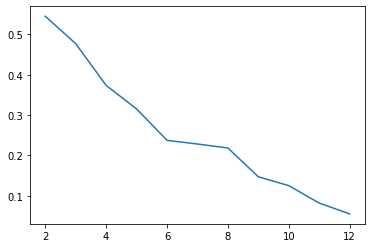

In [75]:
# compute the silhouette scores
k_silhouette = pd.Series(index = k_range, dtype=float)

for k in k_range:
    k_silhouette[k] = metrics.silhouette_score(data_log, elbow_df[k])
    
# plot
fig, ax = plt.subplots()
ax.plot(k_range, k_silhouette)

In [102]:
# output, look at plot, and pick the best k
# I think it is k = 4
# so I'll draw it on now
# best_k = 4
# ax.scatter(best_k, k_silhouette[best_k], color = 'r', s = 50)
# ax.set_xlabel('K')
# ax.set_ylabel('Silhouette Score')

# print('Optimal K =', best_k)

In [95]:
mean_silhouette = pd.Series(index = k_range, dtype=float)

# increase this number to make the curve smoother
# requires a lot of time to run
num_repeats = 10

for k in k_range:
    k_scs = []
    for i in range(num_repeats):
        # DO NOT specify a random state so we intentionally 
        # get different results
        k_clusters = cluster.KMeans(n_clusters = k)
        k_clusters = k_clusters.fit(percs_df.T)
        
        # add this silhouette score
        k_scs += [metrics.silhouette_score(percs_df.T, k_clusters.labels_)]
    
    # take the mean silhouette score
    mean_silhouette[k] = np.mean(k_scs)

In [96]:
X = percs_df
distorsions = []
for k in range(2, 14):
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

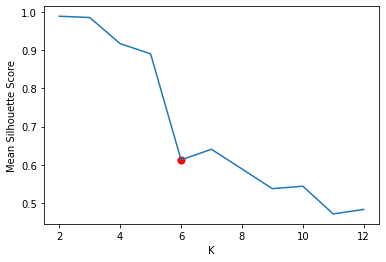

In [103]:
fig, ax = plt.subplots()
ax.plot(k_range, mean_silhouette)
ax.set_xlabel('K')
ax.set_ylabel('Mean Silhouette Score')


# this reduces our k slightly
best_k = 6
ax.scatter(best_k, mean_silhouette[best_k], color = 'r', s = 50)

In [ ]:
k10_clusters = cluster.KMeans(n_clusters =6, random_state = 1)

# compute the clusters
# use the transpose of the data to get samples instead of genes
k10_clusters = k10_clusters.fit(data_log)

# label the output with condition names
k10_labels = pd.Series(k10_clusters.labels_, index = data_log.index)

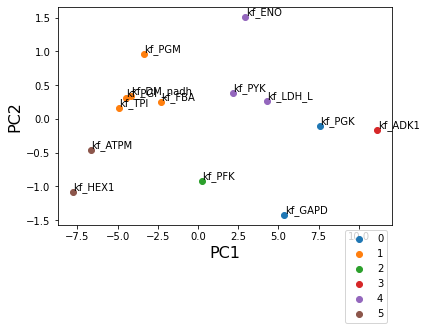

In [105]:
# ANSWER    

ax = PCA_cluster_plot(data_log.T, k10_labels)

In [106]:
data_norm = sklearn.preprocessing.normalize(data_log.T,norm='l2')
data_pc = PCA().fit_transform(data_norm.T)
data_pc = pd.DataFrame(data_pc, index = data_log.index)
plot_data = data_pc.iloc[:,0:2]
plot_data.columns = ["PC1", "PC2"]
plot_data["RXN"] = plot_data.index
plot_data["clusters"] = k10_labels
alt.data_transformers.disable_max_rows()
fig = alt.Chart(plot_data).mark_circle(size= 100).encode(
    alt.X("PC1", axis=alt.Axis( tickCount=5)),
    alt.Y('PC2',axis=alt.Axis( tickCount=5), ), 

    alt.Color('clusters', scale=alt.Scale(scheme='turbo')), 
    tooltip=['RXN']
).properties(
    width=400,
    height=400).interactive()
fig

C:\Users\sicil\AppData\Local\Temp\ipykernel_4416\4012768921.py:6 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\sicil\AppData\Local\Temp\ipykernel_4416\4012768921.py:7 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


alt.Chart(...)

### Making distributions for percs

In [78]:
data_norm = sklearn.preprocessing.normalize(percs_df,norm='l2')
data_norm= pd.DataFrame(data_norm)
data_norm = data_norm.T
data_norm.columns = [data_log.index]
data_norm

RXN,kf_HEX1,kf_PGI,kf_PFK,kf_FBA,kf_TPI,kf_GAPD,kf_PGK,kf_PGM,kf_ENO,kf_PYK,kf_LDH_L,kf_ADK1,kf_ATPM,kf_DM_nadh
0,0.004371,0.029062,0.003945,0.029059,0.018186,0.000461,0.022217,0.024414,0.000513,0.008559,0.005347,0.025734,0.010101,0.010346
1,0.004348,0.004328,0.024420,0.071466,0.018479,0.008078,0.078297,0.027918,0.001254,0.010901,0.002846,0.025734,0.024738,0.018240
2,0.004657,0.005066,0.003696,0.030027,0.026898,0.014328,0.006747,0.023953,0.005108,0.003627,0.009653,0.025734,0.024127,0.037918
3,0.002205,0.009615,0.001656,0.072725,0.065003,0.009915,0.008556,0.064808,0.120200,0.003487,0.005055,0.025734,0.010351,0.020102
4,0.001831,0.008361,0.001371,0.031182,0.022809,0.001087,0.013306,0.021228,0.000887,0.004222,0.001629,0.025734,0.007946,0.008309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,0.024527,0.005965,0.003940,0.004191,0.006145,0.000190,0.123655,0.017401,0.001698,0.053744,0.007297,0.025734,0.043797,0.017755
1506,0.030484,0.011287,0.005403,0.005845,0.006502,0.000080,0.057007,0.011180,0.000677,0.025832,0.004114,0.025734,0.032626,0.015421
1507,0.008158,0.010870,0.002172,0.014017,0.005046,0.000045,0.010948,0.009155,0.000205,0.002086,0.002014,0.025734,0.009937,0.018517
1508,0.005294,0.004652,0.002771,0.010699,0.004649,0.000378,0.006714,0.011166,0.000240,0.007697,0.007300,0.025734,0.017643,0.017362


In [79]:
data_vis = percs_df.T.melt()
data_vis.columns = ["RXN", "val"]

In [80]:
alt.data_transformers.disable_max_rows()
fig = alt.Chart(data_vis).mark_circle(size= 100).encode(
    alt.X("RXN", axis=alt.Axis( tickCount=5), scale=alt.Scale(type='log')),
    alt.Y('val',axis=alt.Axis( tickCount=5), 
    scale=alt.Scale(type='log')), 

    alt.Color('RXN', scale=alt.Scale(scheme='turbo')), 
    tooltip=['RXN', "val"]
).properties(
    width=400,
    height=400).interactive()
fig

alt.Chart(...)

In [125]:
# Violin Plot of percs distribution without log tranforming
alt.data_transformers.disable_max_rows()
alt.Chart(data_vis).transform_density(
    'val',
    as_=['Value_column', 'density'],    
    extent=[-0.1, 1000],
    groupby=['RXN']
    ).mark_area(orient='horizontal').encode(
    y=alt.Y('Value_column:Q',axis=alt.Axis(grid=False,ticks=True)),
    color='RXN:N',
    x=alt.X('density:Q', stack='center',impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True)),
        tooltip=['RXN:N', "Value_column:Q"], 
    column=alt.Column(
        'RXN:N',header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0))
).properties(
    width=50).configure_facet(spacing=0).configure_view(stroke=None).interactive()

alt.Chart(...)

In [86]:
pca = decomposition.PCA().fit(data_norm.T)

# get the two important matrices & label them in pandas
pc_genes = pd.DataFrame(pca.components_,
                        columns = data_norm.index)
pc_samples = pd.DataFrame(pca.transform(data_norm.T),
                          index = data_norm.columns)

# get the explained variance, which will be useful later
exp_var = pca.explained_variance_ratio_

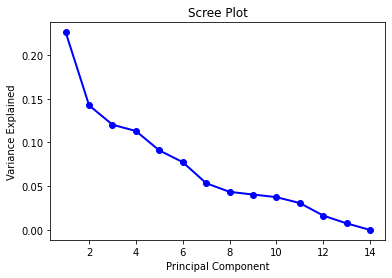

In [87]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [89]:
# get the cumulative variance
cum_var = exp_var.cumsum()

In [138]:
cum_var

array([0.22607828, 0.36855948, 0.48887309, 0.60198984, 0.69288847,
       0.77044049, 0.82388529, 0.86742413, 0.9079162 , 0.94538027,
       0.97612338, 0.99252639, 1.        , 1.        ])

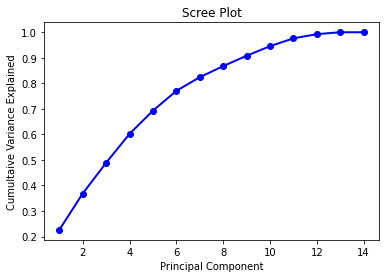

In [90]:
plt.plot(PC_values, cum_var, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Cumultaive Variance Explained')
plt.show()

Components to capture at least 80% of variance:  7


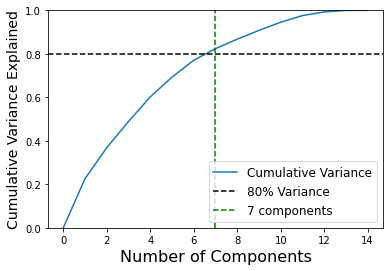

In [127]:
# find the number of components
index_80 = sum(cum_var <= 0.8)

# indices are zero-indexed, so the total number is one more than this
print('Components to capture at least 80% of variance: ', index_80+1)

# add a zero at the start so the plot extends all the way down
cum_var_plot = [0] + list(cum_var)

# plot
fig, ax = plt.subplots()
ax.plot(range(len(cum_var_plot)), cum_var_plot, label = 'Cumulative Variance')

# add some lines to illustrate the question
ax.axhline(0.8, color = 'k', linestyle = '--', label = '80% Variance')
ax.axvline(index_80+1, color = 'g', linestyle = '--', label = str(index_80+1)+ ' components')

# limit the y axes
ax.set_ylim([0, 1])

# axes labels and legend
ax.set_xlabel('Number of Components', fontsize = 16)
ax.set_ylabel('Cumulative Variance Explained', fontsize = 14)
_ = ax.legend(fontsize = 12)

In [92]:
from sklearn.preprocessing import StandardScaler

In [93]:
df_st =  StandardScaler().fit_transform(percs_df.T)  
pd.DataFrame(df_st, columns=percs_df.T.columns).head(2)

RXN,kf_HEX1,kf_PGI,kf_PFK,kf_FBA,kf_TPI,kf_GAPD,kf_PGK,kf_PGM,kf_ENO,kf_PYK,kf_LDH_L,kf_ADK1,kf_ATPM,kf_DM_nadh
0,-0.613392,0.604384,-0.764383,0.597987,-0.107238,-0.084724,0.287090,0.287075,-0.125633,-0.392130,-0.529149,0.0,-0.878444,-0.803406
1,-0.614546,-0.731293,0.349041,2.922305,-0.089255,0.212857,3.134338,0.497761,-0.096521,-0.274292,-0.653295,0.0,0.208540,-0.239500


In [94]:
pca_out = PCA().fit(df_st)
pca_out.explained_variance_ratio_
np.cumsum(pca_out.explained_variance_ratio_)
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = percs_df.T.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
variable,,,,,,,,,,,,,,
kf_HEX1,4.711905e-01,-1.734354e-01,7.565149e-02,8.379088e-02,2.069739e-01,4.931696e-02,-1.000063e-01,-3.503736e-01,1.462208e-01,-6.391361e-01,1.265775e-02,-1.352630e-01,-3.298341e-01,0.000000e+00
kf_PGI,7.799132e-02,-1.309843e-01,-1.731531e-01,3.105710e-02,-7.528129e-01,1.042282e-02,4.108158e-01,2.433137e-02,-6.046852e-02,-3.486727e-01,2.249908e-01,2.308593e-03,1.837420e-01,1.276295e-16
kf_PFK,4.820341e-01,-2.028409e-01,-1.434135e-01,3.051627e-02,-3.001708e-01,6.272533e-02,5.785319e-02,-4.116577e-02,-2.292253e-02,5.526042e-01,-2.680633e-01,8.947880e-03,-4.775842e-01,-2.435790e-16
kf_FBA,-5.851048e-02,1.682923e-01,-1.817376e-02,6.736606e-01,-9.711364e-02,-5.821454e-03,-2.073284e-02,2.177880e-01,6.686683e-01,1.193556e-02,-9.237980e-02,-2.973984e-02,-1.003043e-02,1.343064e-16
kf_TPI,5.367074e-02,4.595242e-02,8.421292e-02,7.058591e-01,5.462805e-02,-6.725862e-02,-1.224503e-02,-1.103490e-01,-6.784600e-01,7.663637e-03,-4.426751e-02,-1.546141e-02,8.531640e-02,-2.333487e-16
kf_GAPD,2.967909e-02,-7.973913e-02,-2.697727e-02,4.457771e-02,4.586159e-01,2.272347e-03,8.772070e-01,4.477309e-02,5.166556e-02,5.559361e-02,-3.022269e-02,2.341398e-02,-3.152634e-02,-8.522516e-17
kf_PGK,2.864462e-01,4.583283e-01,3.380223e-01,-1.693108e-02,-1.387662e-02,-7.302971e-02,4.580282e-02,1.494484e-01,-1.873338e-02,1.236088e-01,6.736636e-01,1.812452e-01,-2.471372e-01,6.135993e-16
kf_PGM,-9.738762e-02,4.269162e-01,3.197652e-01,-5.468011e-02,-1.960803e-01,9.378366e-02,1.775948e-01,-7.184375e-01,1.248543e-01,1.455598e-01,-2.040510e-01,-1.287601e-01,1.144166e-01,-2.386995e-16
kf_ENO,-3.659386e-02,6.455497e-02,1.211799e-01,1.869350e-02,-1.699479e-03,9.615644e-01,5.417063e-03,1.973734e-01,-9.517282e-02,-6.417677e-02,-3.304147e-02,-3.941629e-03,-3.976283e-02,-1.936217e-16


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

Generated correlation matrix plot for loadings

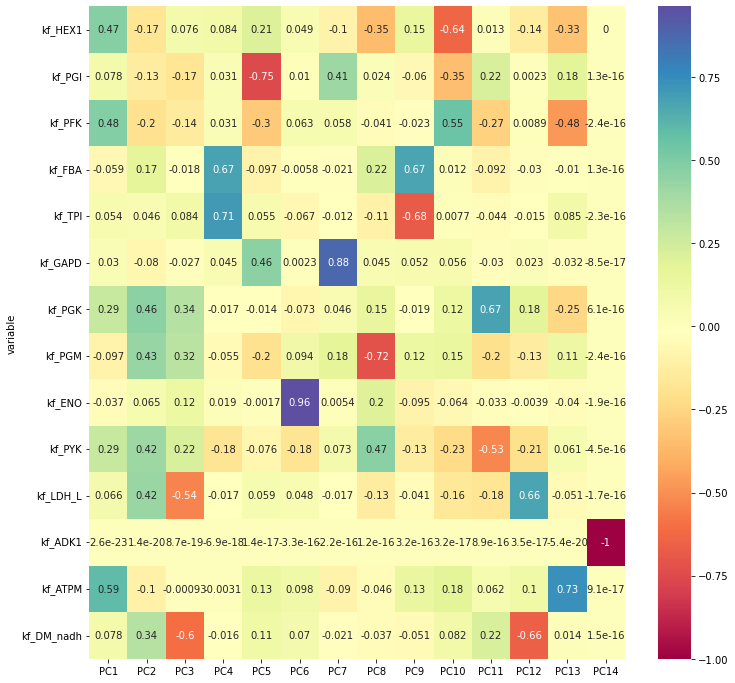

In [135]:
plt.figure(figsize= (12,12))
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
heatmap_sns = os.path.join(data_dir,"heatmap.png")
# Saving figure by changing parameter values
plt.savefig(heatmap_sns, pad_inches=0.3)
plt.show()

In [136]:
qcqa_model(glycolysis, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)



╒══════════════════════════════════════════════╕
│ MODEL ID: Glycolysis                         │
│ SIMULATABLE: True                            │
│ PARAMETERS NUMERICALY CONSISTENT: True       │
╞══════════════════════════════════════════════╡
│ ============================================ │
│             CONSISTENCY CHECKS               │
│ ============================================ │
│ Elemental                                    │
│ ----------------------                       │
│ DM_nadh: {charge: 2.0}                       │
│ ============================================ │
╘══════════════════════════════════════════════╛


Successfully loaded MassModel 'Glycolysis' into RoadRunner.


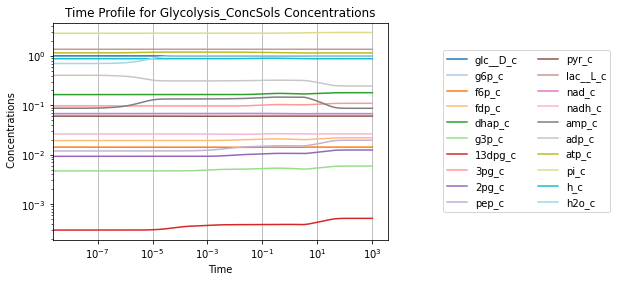

In [137]:
# Setup simulation object
sim = Simulation(glycolysis, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis, time=(0, 1e3))
# Quickly render and display time profiles
conc_sol.view_time_profile()